In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [3]:
import pickle as pkl
from PixelEM import * 

/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [41]:
sample = "10workers_rand0"
objid = 5
algo = "GT"
tiles = pkl.load(open("../analysis/pixel_em/{}/obj{}/tiles.pkl".format(sample,objid)))
log_probability_in_mask=pkl.load(open("../analysis/pixel_em/{}/obj{}/{}_p_in_mask_ground_truth.pkl".format(sample,objid,algo)))
log_probability_not_in_mask =pkl.load(open("../analysis/pixel_em/{}/obj{}/{}_p_not_in_ground_truth.pkl".format(sample,objid,algo)))

In [42]:
#using ground truth ia for testing purposes
gt = pkl.load(open("../analysis/pixel_em/obj{}/gt.pkl".format(objid)))
gt_idxs = set(zip(*np.where(gt)))

In [108]:
candidate_tiles_lst = []
metric_lst = []
ia_lst = [] 
picked_tiles = []
GT_area = 0. #new ground truth area
ia_cum = 0. #cumulative intersection area

# compute I/O metric for all tiles
for tile in tiles[1:]:#ignore the large outside tile
    #intersection_area = float(len(gt_idxs.intersection(set(tile))))
    pInT = np.exp(log_probability_in_mask[list(tile)[0]]) # all pixels in same tile should have the same pInT
    pNotInT = np.exp(log_probability_not_in_mask[list(tile)[0]])
    norm_pInT = pInT/(pNotInT+pInT) #normalized pInT 
    assert norm_pInT<=1 and norm_pInT>=0
    intersection_area = float(len(tile) * norm_pInT) #estimated intersection area
    #GTintersection_area = float(len(gt_idxs.intersection(set(tile)))) # exact intersection areas
    #print intersection_area,GTintersection_area,norm_pInT,len(tile)
    #intersection_area = GTintersection_area# for testing purposes only
    outside_area = float(len(tile) - intersection_area)
    if outside_area!=0: 
        metric = intersection_area/outside_area
        metric_lst.append(metric)
        candidate_tiles_lst.append(tile)
        ia_lst.append(intersection_area)
    else:# if outside area =0, then tile completely encapsulated by GT, it must be included in picked tiles
        #print "here"
        picked_tiles.append(tile)
        GT_area+= len(tile)
        ia_cum += intersection_area

In [109]:
sum([len(t) for t in picked_tiles])

3620

In [110]:
GT_area

3620.0

In [111]:
ia_cum

3620.0

In [112]:
assert len(metric_lst)==len(candidate_tiles_lst)==len(ia_lst)
srt_decr_idx = np.argsort(metric_lst)[::-1] # sorting from largest to smallest metric_lst
jaccard_lst = []
prev_jac = -1000
for tidx  in srt_decr_idx:
    tile = candidate_tiles_lst[tidx]
    ia = ia_lst[tidx]
    jaccard = (ia_cum+ia)/float(GT_area+len(tile)) # the new jaccard if that tile is actually added
    jaccard_lst.append(jaccard)
    if jaccard >= prev_jac: 
        picked_tiles.append(tile)
        # if tile picked, update new ia and area
        prev_jac=jaccard
        ia_cum +=ia
        GT_area += len(tile)
    else: # stop when jaccard starts decreasing after the addition of a tile
        #break
        continue #for debugging purposes to see how jaccard_lst evolves, technically should break here

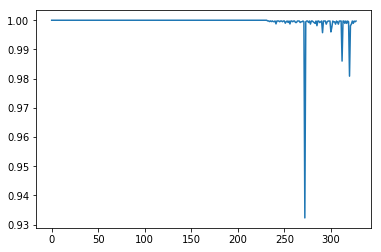

In [113]:
plt.plot(jaccard_lst)

In [114]:
len(picked_tiles)

250

In [115]:
img = np.zeros_like(log_probability_in_mask)
for t in picked_tiles:
    for tidx in t:
        img[tidx]=1

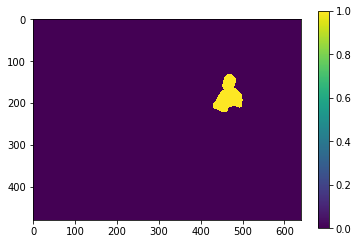

In [116]:
plt.imshow(img)
plt.colorbar()

In [117]:
intersection = (len(np.where(gt*1.==img)[0])-len(np.where(img==0)[0]))

In [118]:
p = intersection/float(len(np.where(gt*1.==1)[0]))
r = intersection/float(len(np.where(img==1)[0]))
j = intersection / float((len(np.where(gt*1.==1)[0]))+(len(np.where(img==1)[0]))-intersection)

In [119]:
print p,r,j

0.790071622623 0.856263383298 0.697557784562


In [120]:
def plot_tile(tile):
    img = np.zeros_like(log_probability_in_mask)
    for tidx in tile:
        img[tidx]=1
    plt.imshow(img)
    plt.colorbar()